In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os
import scipy.optimize as optimize
import scipy.stats as stats

In [ ]:
''' RED PAPER 02/05/23  '''

In [2]:
''' 1 '''
################################'Generate X and Y'##############################
################################ Xt ~ N(0,1)
################################ Yt = α + βYt-1 + γXt + εt + θεt-1
def generate_data(T, alpha_y, beta_y, gamma, theta, sigma_y, mu, seed=None):
    np.random.seed(seed)
    df = pd.DataFrame(index=range(T), columns=['x', 'y', 'epsilon_y'])
    x = np.random.normal(0, 1, T)
    y1 = np.random.normal(mu, sigma_y)
    epsilon_y = sigma_y*np.random.randn(T)
    df.iloc[0,:] = [x[0], y1, epsilon_y[0]]
    
    for i in range(0, T-1):
        df.iloc[i+1,0] = x[i+1] 
        # Xt ~ N(0,1)
        df.iloc[i+1,1] = alpha_y + beta_y * df.iloc[i,1] + gamma * df.iloc[i+1,0] + epsilon_y[i+1] + theta * epsilon_y[i] # generate Y(t) recursively
        # Yt = α + βYt-1 + γXt + εt + θεt-1
        df.iloc[i+1,2] = epsilon_y[i+1]
    
    return df

In [3]:
df = generate_data(1000, 0.2, 0.5, 0.3, 0.9, 1, 0, seed=42)
print(df)

            x         y epsilon_y
0    0.496714  1.399355  0.924634
1   -0.138264  1.749999   0.05963
2    0.647689  0.676037 -0.646937
3     1.52303  1.110908  0.698223
4   -0.234153  1.707094  0.393485
..        ...       ...       ...
995   -0.2811  2.353144 -0.026521
996  1.797687  1.010134 -0.881875
997  0.640843 -0.059434 -0.163067
998 -0.571179 -0.892734 -0.744903
999  0.572583 -1.420183 -0.675178

[1000 rows x 3 columns]


In [5]:
##generate_data(T, alpha, beta, sigma, alpha_y, beta_y, gamma, theta, sigma_y, mu)
#df = generate_data(1000, 1, 0.9, 3, 6, 0.3, 0.9, 0.9, 8, 1.7) i+uncomment to make like sim5
#df = generate_data(1000, 1, 0.9, 0.1, 1, 0.9, 0.9, 0.5, 0.1, 0) #this is for autocorr to be decreasing linearly

In [ ]:
def ols_gls_estimationM(df, M, initial_params):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['Y'].values
    T = min(M, len(y_dataset))
    y = df['Y'].values[:T]
    x = df['X'].values[:T]  # extract data
    
    ols_alpha_hat = []
    ols_beta_hat = []
    ols_gamma_hat = []
    ols_theta_hat = []
    gls_alpha_hat = []
    gls_beta_hat = []
    gls_gamma_hat = []
    gls_theta_hat = []
    y_new = np.zeros(M+1)
    y_new[0] = y[0]

    beta = 0.5
    gamma = 0.3
    
    np.random.seed(123)

    for i in range(1, M+1):  
        epsilon = np.random.randn(T)
        for j in range(T):
            y_new[j] = beta * y_new[j-1] + gamma * x[j] + epsilon[j]

        # OLS estimation of the parameters
        y_lag = np.roll(y_new, 1)
        y_lag[0] = 0
        epsilon_lag = np.roll(epsilon, 1)
        epsilon_lag[0] = 0
        y_lag = y_lag[:T]
        X = np.column_stack((np.ones_like(x)[:T], y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls = np.concatenate((beta_gls, [theta_gls[0, 0]]))

        # Store parameter estimates
        ols_alpha_hat.append(beta_hat[0])
        ols_beta_hat.append(beta_hat[1])
        ols_gamma_hat.append(beta_hat[2])
        ols_theta_hat.append(theta_hat[0, 0])
        gls_alpha_hat.append(beta_gls[0])
        gls_beta_hat.append(beta_gls[1])
        gls_gamma_hat.append(beta_gls[2])
        gls_theta_hat.append(theta_gls[0, 0])

        # Check convergence to initial parameters
        if np.allclose([ols_alpha_hat[-1], ols_beta_hat[-1], ols_gamma_hat[-1], ols_theta_hat[-1], gls_alpha_hat[-1], gls_beta_hat[-1], gls_gamma_hat[-1], gls_theta_hat[-1]], initial_params):
            print("Converged after {} iterations".format(_+1))
        break

    # Calculate means
    ols_alpha_mean = np.mean(ols_alpha_hat)
    ols_beta_mean = np.mean(ols_beta_hat)
    ols_gamma_mean = np.mean(ols_gamma_hat)
    ols_theta_mean = np.mean(ols_theta_hat)
    gls_alpha_mean = np.mean(gls_alpha_hat)
    gls_beta_mean = np.mean(gls_beta_hat)
    gls_gamma_mean = np.mean(gls_gamma_hat)
    gls_theta_mean = np.mean(gls_theta_hat)

    # Print or perform further analysis using the means
    print("Parameter means:")
    print("OLS alpha_mean:", ols_alpha_mean)
    print("OLS beta_mean:", ols_beta_mean)
    print("OLS gamma_mean:", ols_gamma_mean)
    print("OLS theta_mean:", ols_theta_mean)
    print("GLS alpha_mean:", gls_alpha_mean)
    print("GLS beta_mean:", gls_beta_mean)
    print("GLS gamma_mean:", gls_gamma_mean)
    print("GLS theta_mean:", gls_theta_mean)
    
    # Return means as a dictionary if needed
    means = {
        "ols_alpha_mean": ols_alpha_mean,
        "ols_beta_mean": ols_beta_mean,
        "ols_gamma_mean": ols_gamma_mean,
        "ols_theta_mean": ols_theta_mean,
        "gls_alpha_mean": gls_alpha_mean,
        "gls_beta_mean": gls_beta_mean,
        "gls_gamma_mean": gls_gamma_mean,
        "gls_theta_mean": gls_theta_mean
    }
    
    return means


In [4]:
''' OLS GLS estimation 1 repetiotion'''
def ols_gls_estimation2(df):
    # convert data to float64 data type
    df = df.astype('float64')
    # extract data
    x = df['x'].values
    y = df['y'].values
    epsilon_y = df['epsilon_y'].values
    T = len(y)

    # OLS estimation of the parameters
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    epsilon_lag = np.roll(epsilon_y, 1)
    epsilon_lag[0] = 0
    X = np.column_stack((np.ones_like(x), y_lag, x))
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
    ε = y - X @ beta_hat
    ε = ε.reshape((-1, 1))
    ε_lag = np.roll(ε, 1)
    ε_lag[0] = 0
    ε_lag = ε_lag.reshape((-1, 1))
    theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
    
    acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
    sigma2 = np.var(ε) * (1 - acf_resid[1])
    sigma2_array = np.full(T, sigma2)
    rho = acf_resid[1] / (1 - acf_resid[1])
    S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
    theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε

    print(sigma2)
    print("OLS parameter estimates:")
    print("alpha_hat = {:.4f}".format(beta_hat[0]))
    print("beta_hat = {:.4f}".format(beta_hat[1]))
    print("gamma_hat = {:.4f}".format(beta_hat[2]))
    print("theta_hat = {:.4f}".format(theta_hat[0, 0]))
    
    print("GLS parameter estimates:")
    print("alpha_gls = {:.4f}".format(beta_gls[0]))
    print("beta_gls = {:.4f}".format(beta_gls[1]))
    print("gamma_gls = {:.4f}".format(beta_gls[2]))
    print("theta_gls = {:.4f}".format(theta_gls[0, 0]))
  
    return beta_hat, theta_hat, beta_gls, theta_gls

def print_parameters_and_biases(beta, actuals):
    biases = actuals - beta # Calculate the biases
    for i, bias in enumerate(biases):
        print(f"bias_param_{i} = {bias:.4f}")
    
    mse = np.mean(np.square(biases)) # Calculate RMSE
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

beta_hat, theta_hat, beta_gls, theta_gls = ols_gls_estimation2(df)
actuals = [0.2, 0.5, 0.3] # True parameters alpha, beta, gamma, theta
print_parameters_and_biases(beta_hat, actuals)
print_parameters_and_biases(beta_gls, actuals)

1.0859999627946417
OLS parameter estimates:
alpha_hat = 0.1665
beta_hat = 0.7437
gamma_hat = 0.2938
theta_hat = 1.0000
GLS parameter estimates:
alpha_gls = 0.2713
beta_gls = 0.5879
gamma_gls = 0.3118
theta_gls = 1.0000
bias_param_0 = 0.0335
bias_param_1 = -0.2437
bias_param_2 = 0.0062
RMSE = 0.1420
bias_param_0 = -0.0713
bias_param_1 = -0.0879
bias_param_2 = -0.0118
RMSE = 0.0657


In [14]:
df = df.astype('float64')
   
x = df['x'].values
y = df['y'].values
epsilon_y = df['epsilon_y'].values
T = len(y)

# OLS estimation of the parameters
y_lag = np.roll(y, 1)
y_lag[0] = 0
epsilon_lag = np.roll(epsilon_y, 1)
epsilon_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
ε = y - X @ beta_hat
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
    
acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
sigma2 = np.var(ε) * (1 - acf_resid[1])
sigma2_array = np.full(T, sigma2)
print(sigma2)
rho = acf_resid[1] / (1 - acf_resid[1])
print(rho)
S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
print(S)
beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε

    
print("OLS parameter estimates:")
print("alpha_hat = {:.4f}".format(beta_hat[0]))
print("beta_hat = {:.4f}".format(beta_hat[1]))
print("gamma_hat = {:.4f}".format(beta_hat[2]))
print("theta_hat = {:.4f}".format(theta_hat[0, 0]))

print("GLS parameter estimates:")
print("alpha_gls = {:.4f}".format(beta_gls[0]))
print("beta_gls = {:.4f}".format(beta_gls[1]))
print("gamma_gls = {:.4f}".format(beta_gls[2]))
print("theta_gls = {:.4f}".format(theta_gls[0, 0]))
  
  
biases = actuals - beta_hat # Calculate the biases
for i, bias in enumerate(biases):
    print(f"bias_param_{i} = {bias:.4f}")
    
mse = np.mean(np.square(biases)) # Calculate RMSE
rmse = np.sqrt(mse)
print(f"RMSE = {rmse:.4f}")

actuals = [0.2, 0.5, 0.3] # True parameters alpha, beta, gamma, theta


1.0859999627946417
0.4349388933424961
[[1.08599996 0.47234362 0.         ... 0.         0.         0.        ]
 [0.47234362 1.08599996 0.47234362 ... 0.         0.         0.        ]
 [0.         0.47234362 1.08599996 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.08599996 0.47234362 0.        ]
 [0.         0.         0.         ... 0.47234362 1.08599996 0.47234362]
 [0.         0.         0.         ... 0.         0.47234362 1.08599996]]
OLS parameter estimates:
alpha_hat = 0.1665
beta_hat = 0.7437
gamma_hat = 0.2938
theta_hat = 1.0000
GLS parameter estimates:
alpha_gls = 0.2713
beta_gls = 0.5879
gamma_gls = 0.3118
theta_gls = 1.0000
bias_param_0 = 0.0335
bias_param_1 = -0.2437
bias_param_2 = 0.0062
RMSE = 0.1420


In [7]:
''' prove 02/06'''
df = df.astype('float64')
x = df['x'].values
y = df['y'].values
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))
z = y - X @ beta_hat
print(beta_hat)
print(np.sum(z))


[0.16649059 0.74366533 0.29377513]
-3.694822225952521e-13


In [7]:
''' M Iterations'''
def ols_gls_estimationM(df, M, initial_params):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['y'].values
    T = min(M, len(y_dataset))
    y = df['y'].values[:T]
    x = df['x'].values[:T]  # extract data
    epsilon_y = df['epsilon_y'].values[:T]

    ols_alpha_hat = []
    ols_beta_hat = []
    ols_gamma_hat = []
    ols_theta_hat = []
    gls_alpha_hat = []
    gls_beta_hat = []
    gls_gamma_hat = []
    gls_theta_hat = []

    np.random.seed(123)
    for i in range(M):
        #epsilon = np.random.normal(T)  # Generate new errors for each iteration
        epsilon = np.random.randn(T) # Generate new errors for each iteration

        y = y + epsilon  # Update y with new errors

        # OLS estimation of the parameters
        y_lag = np.roll(y, 1)
        y_lag[0] = 0
        epsilon_lag = np.roll(epsilon_y, 1)
        epsilon_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls = np.concatenate((beta_gls, [theta_gls[0, 0]]))

        # Store parameter estimates
        ols_alpha_hat.append(beta_hat[0])
        ols_beta_hat.append(beta_hat[1])
        ols_gamma_hat.append(beta_hat[2])
        ols_theta_hat.append(theta_hat[0, 0])
        gls_alpha_hat.append(beta_gls[0])
        gls_beta_hat.append(beta_gls[1])
        gls_gamma_hat.append(beta_gls[2])
        gls_theta_hat.append(theta_gls[0, 0])

        # Check convergence to initial parameters
        if np.allclose([ols_alpha_hat[-1], ols_beta_hat[-1], ols_gamma_hat[-1], ols_theta_hat[-1], gls_alpha_hat[-1], gls_beta_hat[-1], gls_gamma_hat[-1], gls_theta_hat[-1]], initial_params):
            print("Converged after {} iterations".format(_+1))
        break

    # Print or perform further analysis using the stored parameter estimates
    print("Parameter estimates:")
    print("OLS alpha_hat: ", ols_alpha_hat)
    print("OLS beta_hat: ", ols_beta_hat)
    print("OLS gamma_hat: ", ols_gamma_hat)
    print("OLS theta_hat: ", ols_theta_hat)
    print("GLS alpha_hat: ", gls_alpha_hat)
    print("GLS beta_hat: ", gls_beta_hat)
    print("GLS gamma_hat: ", gls_gamma_hat)
    print("GLS theta_hat: ", gls_theta_hat)


    actuals = np.array([0.2, 0.5, 0.3, 0.9])  # True parameters alpha, beta, gamma, theta
  # Calculate the biases
    biases_ols = actuals - np.array(beta_hat)
    for i, bias in enumerate(biases_ols):
        print(f"OLS_bias_param_{i} = {bias:.4f}")
    
    mse_ols = np.mean(np.square(biases_ols)) # Calculate RMSE
    rmse_ols = np.sqrt(mse_ols)
    print(f"OLS_RMSE = {rmse_ols:.4f}")
    
    biases_gls = actuals - np.array(beta_gls) # Calculate the biases
    for i, bias in enumerate(biases_gls):
        print(f"GLS_bias_param_{i} = {bias:.4f}")
    
    mse_gls = np.mean(np.square(biases_gls)) # Calculate RMSE
    rmse_gls = np.sqrt(mse_gls)
    print(f"GLS_RMSE = {rmse_gls:.4f}")


In [8]:
M=1000
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [0.25447061320741066]
OLS beta_hat:  [0.5900422629395783]
OLS gamma_hat:  [0.2512666211612553]
OLS theta_hat:  [0.9999999999999994]
GLS alpha_hat:  [0.27438451057842206]
GLS beta_hat:  [0.5585761912495335]
GLS gamma_hat:  [0.25306784029104556]
GLS theta_hat:  [1.000000000000221]
OLS_bias_param_0 = -0.0545
OLS_bias_param_1 = -0.0900
OLS_bias_param_2 = 0.0487
OLS_bias_param_3 = -0.1000
OLS_RMSE = 0.0766
GLS_bias_param_0 = -0.0744
GLS_bias_param_1 = -0.0586
GLS_bias_param_2 = 0.0469
GLS_bias_param_3 = -0.1000
GLS_RMSE = 0.0727


In [104]:
M=100
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [0.4559455463060822]
OLS beta_hat:  [0.5036939727015716]
OLS gamma_hat:  [-0.09799500195764527]
OLS theta_hat:  [1.0000000000000016]
GLS alpha_hat:  [0.4476169421122218]
GLS beta_hat:  [0.5131011572666253]
GLS gamma_hat:  [-0.09529768894656782]
GLS theta_hat:  [1.0000000000125056]
OLS_bias_param_0 = -0.2559
OLS_bias_param_1 = -0.0037
OLS_bias_param_2 = 0.3980
OLS_bias_param_3 = -0.1000
OLS_RMSE = 0.2418
GLS_bias_param_0 = -0.2476
GLS_bias_param_1 = -0.0131
GLS_bias_param_2 = 0.3953
GLS_bias_param_3 = -0.1000
GLS_RMSE = 0.2386


In [106]:
M=1000
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [0.25447061320741066]
OLS beta_hat:  [0.5900422629395783]
OLS gamma_hat:  [0.2512666211612553]
OLS theta_hat:  [0.9999999999999994]
GLS alpha_hat:  [0.27438451057842206]
GLS beta_hat:  [0.5585761912495335]
GLS gamma_hat:  [0.25306784029104556]
GLS theta_hat:  [1.000000000000221]
OLS_bias_param_0 = -0.0545
OLS_bias_param_1 = -0.0900
OLS_bias_param_2 = 0.0487
OLS_bias_param_3 = -0.1000
OLS_RMSE = 0.0766
GLS_bias_param_0 = -0.0744
GLS_bias_param_1 = -0.0586
GLS_bias_param_2 = 0.0469
GLS_bias_param_3 = -0.1000
GLS_RMSE = 0.0727


In [107]:
M=10000
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [0.25447061320741066]
OLS beta_hat:  [0.5900422629395783]
OLS gamma_hat:  [0.2512666211612553]
OLS theta_hat:  [0.9999999999999994]
GLS alpha_hat:  [0.27438451057842206]
GLS beta_hat:  [0.5585761912495335]
GLS gamma_hat:  [0.25306784029104556]
GLS theta_hat:  [1.000000000000221]
OLS_bias_param_0 = -0.0545
OLS_bias_param_1 = -0.0900
OLS_bias_param_2 = 0.0487
OLS_bias_param_3 = -0.1000
OLS_RMSE = 0.0766
GLS_bias_param_0 = -0.0744
GLS_bias_param_1 = -0.0586
GLS_bias_param_2 = 0.0469
GLS_bias_param_3 = -0.1000
GLS_RMSE = 0.0727


In [ ]:
def ols_gls_estimationM3(df, M, initial_params):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['y'].values
    T = min(M, len(y_dataset))
    y = df['y'].values[:T]
    x = df['x'].values[:T]  # extract data
    epsilon_y = df['epsilon_y'].values[:T]
    
    beta_matrix_OLS = np.zeros((M, 4))  # Empty matrix to store beta parameters
    rmse_matrix_OLS = np.zeros((M, 4)) 
    beta_matrix_GLS = np.zeros((M, 4))  # Empty matrix to store beta parameters
    rmse_matrix_GLS = np.zeros((M, 4)) # Empty matrix to store RMSE values

    np.random.seed(123)
    for i in range(M):
        #epsilon = np.random.normal(T)  # Generate new errors for each iteration
        epsilon = np.random.randn(T) # Generate new errors for each iteration
        #epsilon = laplace_asymmetric.rvs(kappa=0.5, loc=0, scale=1, size=T)
        y_new = y + epsilon  # Update y with new errors

        # OLS estimation of the parameters
        y_lag = np.roll(y_new, 1)
        y_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls_hat = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls_hat = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls_hat = np.concatenate((beta_gls_hat, [theta_gls_hat[0, 0]]))

        beta_matrix_OLS[i, :] = beta_hat 
        beta_matrix_GLS[i, :] = beta_gls_hat  # Store beta parameters in the matrix

        actuals = np.array([0.2, 0.5, 0.3, 0.9])   # True parameters alpha, beta, gamma
        biases_OLS = actuals - np.array(beta_hat)
        mse_OLS = np.mean(np.square(biases_OLS))  # Calculate MSE
        rmse_OLS = np.sqrt(mse_OLS)  # Calculate RMSE
        rmse_matrix_OLS[i, :] = rmse_OLS  # Store RMSE values in the matrix

        biases_GLS = actuals - np.array(beta_gls_hat)
        mse_GLS = np.mean(np.square(biases_GLS))  # Calculate MSE
        rmse_GLS = np.sqrt(mse_GLS)  # Calculate RMSE
        rmse_matrix_GLS[i, :] = rmse_GLS  # Store RMSE values in the matrix

    #print("Beta Matrix OLS:")
    #print(beta_matrix_OLS)
    #print("\nRMSE Matrix OLS:")
    #print(rmse_matrix_OLS)
    print("\nMean of Betas OLS:")
    print(np.mean(beta_matrix_OLS, axis=0))
    print("\nMean of RMSE OLS:")
    print(np.mean(rmse_matrix_OLS))
    #print("Beta Matrix GLS:")
    #print(beta_matrix_GLS)
    #print("\nRMSE Matrix GLS:")
    #print(rmse_matrix_GLS)
    print("\nMean of Betas GLS:")
    print(np.mean(beta_matrix_GLS, axis=0))
    print("\nMean of RMSE GLS:")
    print(np.mean(rmse_matrix_GLS))


    return beta_matrix_OLS, beta_matrix_GLS

initial_params = np.array([0.2, 0.5, 0.3, 0.9])  # True parameters alpha, beta, gamma, theta
result_matrix_OLS = ols_gls_estimationM3(df, 100, initial_params)

In [ ]:
''' modifica del 14/06- nuova estimation rho'''
def ols_gls_estimationM3(df, M, initial_params):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['y'].values
    T = min(M, len(y_dataset))
    y = df['y'].values[:T]
    x = df['x'].values[:T]  # extract data
    epsilon_y = df['epsilon_y'].values[:T]
    
    beta_matrix_OLS = np.zeros((M, 4))  # Empty matrix to store beta parameters
    rmse_matrix_OLS = np.zeros((M, 4)) 
    beta_matrix_GLS = np.zeros((M, 4))  # Empty matrix to store beta parameters
    rmse_matrix_GLS = np.zeros((M, 4)) # Empty matrix to store RMSE values

    np.random.seed(123)
    for i in range(M):
        #epsilon = np.random.normal(T)  # Generate new errors for each iteration
        epsilon = np.random.randn(T) # Generate new errors for each iteration
        #epsilon = laplace_asymmetric.rvs(kappa=0.5, loc=0, scale=1, size=T)
        y_new = y + epsilon  # Update y with new errors

        # OLS estimation of the parameters
        y_lag = np.roll(y_new, 1)
        y_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        rho = np.corrcoef(epsilon_y[:-1], epsilon_y[1:])[0, 1]
        sigma2 = np.var(epsilon_y)
        C = np.cov(epsilon_y[:-1], epsilon_y[1:])[0, 1]

        # Construct the variance-covariance matrix Sigma
        n = len(epsilon_y)
        Sigma = np.zeros((n, n))
        Sigma[np.diag_indices(n)] = sigma2
        for i in range(n):
            for j in range(n):
                if i != j:
                    Sigma[i, j] = C * rho ** np.abs(i - j)

        # Print the constructed variance-covariance matrix
        #print("Variance-Covariance Matrix (Sigma):")
        #print(Sigma)

        #acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        #sigma2 = np.var(ε) * (1 - acf_resid[1])
        #sigma2_array = np.full(T, sigma2)
        #rho = acf_resid[1] / (1 - acf_resid[1])
        #S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls_hat = np.linalg.inv(X.T @ np.linalg.inv(Sigma) @ X) @ X.T @ np.linalg.inv(Sigma) @ y
        theta_gls_hat = np.linalg.inv(ε.T @ np.linalg.inv(Sigma) @ ε_lag) @ ε_lag.T @ np.linalg.inv(Sigma) @ ε
        beta_gls_hat = np.concatenate((beta_gls_hat, [theta_gls_hat[0, 0]]))

        beta_matrix_OLS[i, :] = beta_hat 
        beta_matrix_GLS[i, :] = beta_gls_hat  # Store beta parameters in the matrix

        actuals = np.array([0.2, 0.5, 0.3, 0.9])   # True parameters alpha, beta, gamma
        biases_OLS = actuals - np.array(beta_hat)
        mse_OLS = np.mean(np.square(biases_OLS))  # Calculate MSE
        rmse_OLS = np.sqrt(mse_OLS)  # Calculate RMSE
        rmse_matrix_OLS[i, :] = rmse_OLS  # Store RMSE values in the matrix

        biases_GLS = actuals - np.array(beta_gls_hat)
        mse_GLS = np.mean(np.square(biases_GLS))  # Calculate MSE
        rmse_GLS = np.sqrt(mse_GLS)  # Calculate RMSE
        rmse_matrix_GLS[i, :] = rmse_GLS  # Store RMSE values in the matrix

    #print("Beta Matrix OLS:")
    #print(beta_matrix_OLS)
    #print("\nRMSE Matrix OLS:")
    #print(rmse_matrix_OLS)
    print("\nMean of Betas OLS:")
    print(np.mean(beta_matrix_OLS, axis=0))
    print("\nMean of RMSE OLS:")
    print(np.mean(rmse_matrix_OLS))
    #print("Beta Matrix GLS:")
    #print(beta_matrix_GLS)
    #print("\nRMSE Matrix GLS:")
    #print(rmse_matrix_GLS)
    print("\nMean of Betas GLS:")
    print(np.mean(beta_matrix_GLS, axis=0))
    print("\nMean of RMSE GLS:")
    print(np.mean(rmse_matrix_GLS))


    return beta_matrix_OLS, beta_matrix_GLS

initial_params = np.array([0.2, 0.5, 0.3, 0.9])  # True parameters alpha, beta, gamma, theta
result_matrix_OLS = ols_gls_estimationM3(df, 100, initial_params)

In [ ]:
def ols_gls_estimationM2(df, M, initial_params, quantiles):
    df = df.astype('float64')  # convert data to float64 data type
    y_dataset = df['y'].values
    T = min(M, len(y_dataset))
    y = df['y'].values[:T]
    x = df['x'].values[:T]  # extract data
    epsilon_y = df['epsilon_y'].values[:T]

    ols_alpha_hat = []
    ols_beta_hat = []
    ols_gamma_hat = []
    ols_theta_hat = []
    gls_alpha_hat = []
    gls_beta_hat = []
    gls_gamma_hat = []
    gls_theta_hat = []

    np.random.seed(123)
    for i in range(M):
        epsilon = np.random.randn(T)  # Generate new errors for each iteration

        y_updated = y + epsilon  # Update y with new errors

        # OLS estimation of the parameters
        y_lag = np.roll(y_updated, 1)
        y_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls = np.concatenate((beta_gls, [theta_gls[0, 0]]))

        # Store parameter estimates
        ols_alpha_hat.append(beta_hat[0])
        ols_beta_hat.append(beta_hat[1])
        ols_gamma_hat.append(beta_hat[2])
        ols_theta_hat.append(theta_hat[0, 0])
        gls_alpha_hat.append(beta_gls[0])
        gls_beta_hat.append(beta_gls[1])
        gls_gamma_hat.append(beta_gls[2])
        gls_theta_hat.append(theta_gls[0, 0])

        # Check convergence to initial parameters
        if np.allclose([ols_alpha_hat[-1], ols_beta_hat[-1], ols_gamma_hat[-1], ols_theta_hat[-1], gls_alpha_hat[-1], gls_beta_hat[-1], gls_gamma_hat[-1], gls_theta_hat[-1]], initial_params):
            print("Converged after {} iterations".format(i + 1))

    # Print or perform further analysis using the stored parameter estimates
    print("Parameter estimates:")
    print("OLS alpha_hat: ", ols_alpha_hat)
    print("OLS beta_hat: ", ols_beta_hat)
    print("OLS gamma_hat: ", ols_gamma_hat)
    print("OLS theta_hat: ", ols_theta_hat)
    print("GLS alpha_hat: ", gls_alpha_hat)
    print("GLS beta_hat: ", gls_beta_hat)
    print("GLS gamma_hat: ", gls_gamma_hat)
    print("GLS theta_hat: ", gls_theta_hat)

    actuals = np.array([0.2, 0.5, 0.3, 0.9])  # True parameters alpha, beta, gamma, theta

    for p in quantiles:
        beta_quantile_hat_ols = np.percentile(ols_beta_hat, p)
        beta_quantile_hat_gls = np.percentile(gls_beta_hat, p)
        print(f"Quantile {p}% - OLS beta_hat: {beta_quantile_hat_ols:.4f}, GLS beta_hat: {beta_quantile_hat_gls:.4f}")

    biases_ols = actuals - np.array(beta_hat)
    mse_ols = np.mean(np.square(biases_ols))
    rmse_ols = np.sqrt(mse_ols)
    print(f"OLS_RMSE = {rmse_ols:.4f}")

    biases_gls = actuals - np.array(beta_gls)
    mse_gls = np.mean(np.square(biases_gls))
    rmse_gls = np.sqrt(mse_gls)
    print(f"GLS_RMSE = {rmse_gls:.4f}")

In [ ]:
M=100
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
quantiles = 10, 50, 90
ols_gls_estimationM2(df, M, initial_params, quantiles)

In [9]:

################################ Quantile linear regression with package ################################
def fit_quantile(df):
    y = df['y'].values.astype(float)
    x = df['x'].values.astype(float)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    
    X = np.column_stack((np.ones_like(x), y_lag, x))

    quant_reg_1 = sm.QuantReg(y, X).fit(q=0.1)
    quant_reg_5 = sm.QuantReg(y, X).fit(q=0.5)
    quant_reg_9 = sm.QuantReg(y, X).fit(q=0.9)

    # Plot the scatter data and the quantile regression lines
    fig, ax = plt.subplots()
    ax.scatter(x, y, alpha=0.5)

    # Generate x values for the regression lines
    x_vals = np.linspace(np.min(x), np.max(x), 100)

    # Plot the regression lines
    ax.plot(x_vals, quant_reg_1.params[0] + quant_reg_1.params[1]*0 + quant_reg_1.params[2]*x_vals, 'r', label='Quantile level: 0.1')
    ax.plot(x_vals, quant_reg_5.params[0] + quant_reg_5.params[1]*0 + quant_reg_5.params[2]*x_vals, 'g', label='Quantile level: 0.5')
    ax.plot(x_vals, quant_reg_9.params[0] + quant_reg_9.params[1]*0 + quant_reg_9.params[2]*x_vals, 'b', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Quantile regression at different quantile levels')

    plt.show()

################################ Autocorrelation of the residuals ##############################
    residuals_1 = quant_reg_1.resid # Calculate the residuals
    residuals_5 = quant_reg_5.resid # Calculate the residuals
    residuals_9 = quant_reg_9.resid # Calculate the residuals

    # Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
    fig, ax = plt.subplots(3, 1, figsize=(8, 10))
    plot_acf(quant_reg_1.resid, ax=ax[0])
    ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
    plot_acf(quant_reg_5.resid, ax=ax[1])
    ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
    plot_acf(quant_reg_9.resid, ax=ax[2])
    ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
    plt.tight_layout()
    plt.show()

    return quant_reg_1.summary(), quant_reg_5.summary(), quant_reg_9.summary()

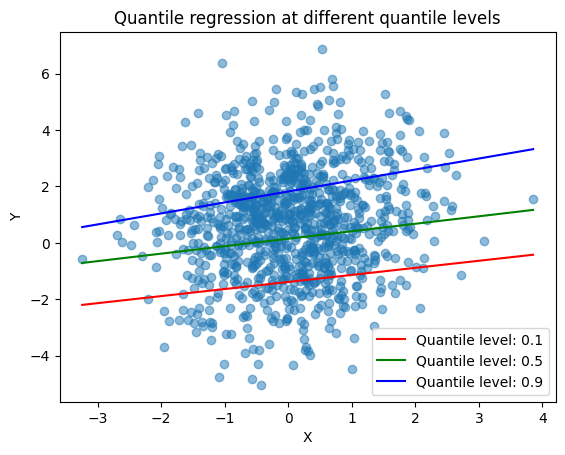

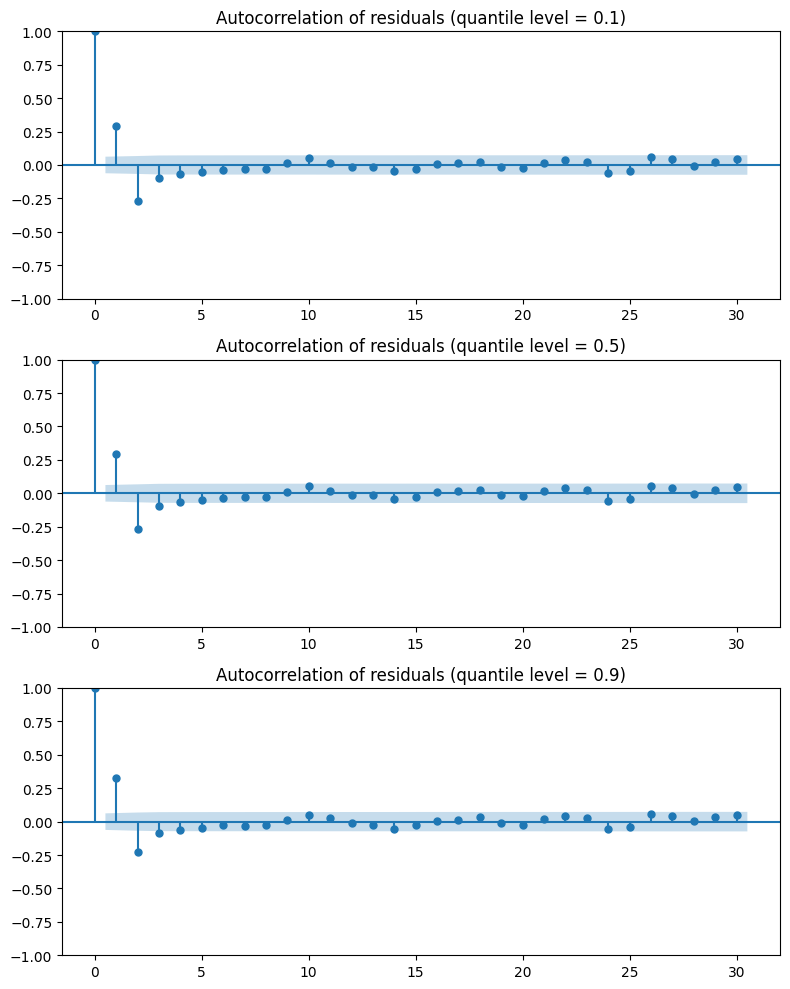

(<class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable:                      y   Pseudo R-squared:               0.3451
 Model:                       QuantReg   Bandwidth:                      0.4867
 Method:                 Least Squares   Sparsity:                        7.633
 Date:                Sat, 24 Jun 2023   No. Observations:                 1000
 Time:                        14:18:43   Df Residuals:                      997
                                         Df Model:                            2
                  coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const         -1.3888      0.078    -17.845      0.000      -1.542      -1.236
 x1             0.7595      0.040     18.828      0.000       0.680       0.839
 x2             0.2507      0.077      3.277      0.001       0.101   

In [10]:
fit_quantile(df)

In [7]:
''' 2.A OLS Liklihood            B method  results close to beta above'''

def OLS_loglikelihood(params, x, y):
    alpha, beta, gamma, theta, sigma = params
    T = len(y)
    ll = 0
    for t in range(1, T):
        mu = alpha + beta * y[t-1] + gamma * x[t] #X𝛽
        sigma2 = sigma**2 * (1 + theta**2)
        ll += -T/2 * np.log(2*np.pi) - T/2 * np.log(sigma2) - T/(2*sigma2) * np.sum((y[t]-mu)**2)
    return -ll

x = df['x'].values # Load data
y = df['y'].values

params0 = np.array([0.1, 0.1, 0.1, 0.1, 0.1]) # Initial parameter values

# Run optimization to find MLE
result = optimize.minimize(OLS_loglikelihood, params0, args=(x, y), method='L-BFGS-B', bounds=[(-np.inf, np.inf), (-1, 1), (-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf)])
beta_2 = result.x
print('Estimated alpha:', result.x[0]) # Print estimated parameters
print('Estimated beta:', result.x[1])
print('Estimated gamma:', result.x[2])
print('Estimated theta:', result.x[3])
print('Estimated sigma:', result.x[4])

def print_parameters_and_biases(beta, actuals):
    biases = actuals - beta # Calculate the biases
    for i, bias in enumerate(biases):
        print(f"bias_param_{i} = {bias:.4f}")
    
    mse = np.mean(np.square(biases)) # Calculate RMSE
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")


actuals = [0.2, 0.5, 0.3, 0.9, 1] # True parameters alpha, beta, gamma, theta
print_parameters_and_biases(beta_2, actuals)

Estimated alpha: 0.16528272507481268
Estimated beta: 0.7438567142934158
Estimated gamma: 0.29325373665152304
Estimated theta: 0.07972997422575029
Estimated sigma: 1.2445370923378432
bias_param_0 = 0.0347
bias_param_1 = -0.2439
bias_param_2 = 0.0067
bias_param_3 = 0.8203
bias_param_4 = -0.2445
RMSE = 0.3983


In [140]:
''' 2.B GLS Liklihood  with β_ols values       (exact same results as β_gls above)
'''
def GLS_logliklihood(df):
    df = df.astype('float64') # convert data to float64 data type
    x = df['x'].values # extract data
    y = df['y'].values
    epsilon_y = df['epsilon_y'].values
    T = len(y)

    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    epsilon_lag = np.roll(epsilon_y, 1)
    epsilon_lag[0] = 0
    X = np.column_stack((np.ones_like(x), y_lag, x))
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y  # OLS estimation of the parameters
    
    ε = y - X @ beta_hat
    ε = ε.reshape((-1, 1))
    ε_lag = np.roll(ε, 1)
    ε_lag[0] = 0
    ε_lag = ε_lag.reshape((-1, 1))
    theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
    
    acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
    sigma2 = np.var(ε) * (1 - acf_resid[1])
    sigma2_array = np.full(T, sigma2)
    rho = acf_resid[1] / (1 - acf_resid[1])
    S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    
    def neg_log_likelihood(beta_hat, X, y, S):
        T  = len(y)
        resid = y - X @ beta_hat
        return T/2 * np.log(np.linalg.det(S)) + T/2 * resid.T @ np.linalg.inv(S) @ resid
    beta_guess = np.zeros(X.shape[1]) # initial guess for beta
    res = optimize.minimize(neg_log_likelihood, beta_hat, args=(X, y, S)) # minimize the negative log-likelihood
    beta_gls = res.x # the estimated beta is in res.x

    print("GLS parameter estimates:")
    print("alpha_gls = {:.4f}".format(beta_gls[0]))
    print("beta_gls = {:.4f}".format(beta_gls[1]))
    print("gamma_gls = {:.4f}".format(beta_gls[2]))
    #print("theta_gls = {:.4f}".format(theta_gls[0, 0]))
    
    def print_parameters_and_biases(beta, actuals):
        biases = actuals - beta # Calculate the biases
        for i, bias in enumerate(biases):
            print(f"bias_param_{i} = {bias:.4f}")
    
        mse = np.mean(np.square(biases)) # Calculate RMSE
        rmse = np.sqrt(mse)
        print(f"RMSE = {rmse:.4f}")


actuals = [0.2, 0.5, 0.3] # True parameters alpha, beta, gamma, theta
print_parameters_and_biases(beta_hat, actuals)
print_parameters_and_biases(beta_gls, actuals)


bias_param_0 = 0.0335
bias_param_1 = -0.2437
bias_param_2 = 0.0062
RMSE = 0.1420
bias_param_0 = -0.0713
bias_param_1 = -0.0879
bias_param_2 = -0.0118
RMSE = 0.0657


In [55]:
''' 2.C GLS Liklihoood that takes OLS liklihood values'''
#def OLS_GLS_loglikelihood(d):


def OLS_loglikelihood(params, x, y):
    alpha, beta, gamma, theta, sigma = params
    T = len(y)
    ll = 0
    for t in range(1, T):
        mu = alpha + beta * y[t-1] + gamma * x[t] #X𝛽
        sigma2 = sigma**2 * (1 + theta**2)
        ll += -T/2 * np.log(2*np.pi) - T/2 * np.log(sigma2) - T/(2*sigma2) * np.sum((y[t]-mu)**2)
    return -ll

x = df['x'].values # Load data
y = df['y'].values

params0 = np.array([0.1, 0.1, 0.1, 0.1, 0.1]) # Initial parameter values

result = optimize.minimize(OLS_loglikelihood, params0, args=(x, y), method='L-BFGS-B', bounds=[(-np.inf, np.inf), (-1, 1), (-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf)])

beta_hat = result.x[:3] # Store the first 3 estimated parameters
theta_hat = result.x[3]
sigma_hat = result.x[4] # Store the last estimated parameter as sigma

print('Estimated alpha:', beta_hat[0]) # Print estimated parameters
print('Estimated beta:', beta_hat[1])
print('Estimated gamma:', beta_hat[2])
print('Estimated theta:', theta_hat)
print('Estimated sigma:', sigma_hat)

df = df.astype('float64') # convert data to float64 data type

T = len(y)

y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))

ε = y - X @ beta_hat # Calculate residuals using estimated parameters
    
ε = ε.reshape((-1, 1))
    
acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
sigma2 = np.var(ε) * (1 - acf_resid[1])
sigma2_array = np.full(T, sigma2)
rho = acf_resid[1] / (1 - acf_resid[1])
S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    
def neg_log_likelihood(beta_hat, X, y, S):
    T  = len(y)
    resid = y - X @ beta_hat
    return T/2 * np.log(np.linalg.det(S)) + T/2 * resid.T @ np.linalg.inv(S) @ resid
beta_guess = np.zeros(X.shape[1]) # initial guess for beta
res = optimize.minimize(neg_log_likelihood, beta_hat, args=(X, y, S)) # minimize the negative log-likelihood
beta_gls = res.x # the estimated beta is in res.x

print("GLS parameter estimates:")
print("alpha_gls = {:.4f}".format(beta_gls[0]))
print("beta_gls = {:.4f}".format(beta_gls[1]))
print("gamma_gls = {:.4f}".format(beta_gls[2]))
#print("theta_gls = {:.4f}".format(theta_gls[0, 0])) 
                                                            #''' ***************QUESTION************** '''


Estimated alpha: 0.16528272507481268
Estimated beta: 0.7438567142934158
Estimated gamma: 0.29325373665152304
Estimated theta: 0.07972997422575029
Estimated sigma: 1.2445370923378432


KeyboardInterrupt: 

In [62]:
''' 3.A logliklihood_asymmetric_Laplace with β_ols values    --> very similar to just OLS '''
def logliklihood_asymmetric_Laplace(df, p):
    df = df.astype('float64') # convert data to float64 data type
    x = df['x'].values # extract data
    y = df['y'].values
    T = len(y)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    X = np.column_stack((np.ones_like(x), y_lag, x)) 
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y  # OLS estimation of the parameters

    #Laplace
    z = np.random.exponential(1, T)
    τ_2 = 2 / p * (1-p)
    θ = (1 - 2*p) / p * (1-p)
    ε = y - X @ beta_hat - θ * z
    ε = ε.reshape((-1, 1))
    
    acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
    sigma2 = np.var(ε) * (1 - acf_resid[1])
    sigma2_array = np.full(T, sigma2)
    rho = acf_resid[1] / (1 - acf_resid[1])
    S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    
    def neg_log_likelihood(X, y, S):
        T  = len(y)
        #resid = y - X @ beta_hat - θ * z
        a = (np.sqrt(τ_2)*np.sqrt(z))**2
        b = (ε**2)/a       
        return np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(b))
    
    initial_values = [0.2, 0.5, 0.3]
    res = optimize.minimize(neg_log_likelihood, initial_values, args=(X, y, S)) # minimize the negative log-likelihood
    beta_laplace = res.x # the estimated beta is in res.x

        
    print("Laplace parameter estimates:")
    print("alpha_l = {:.4f}".format(beta_laplace[0]))
    print("beta_l = {:.4f}".format(beta_laplace[1]))
    print("gamma_l = {:.4f}".format(beta_laplace[2]))
    #print("theta_gls = {:.4f}".format(theta_gls[0, 0]))
        
    actuals = [0.2, 0.5, 0.3]
    biases = actuals - beta_laplace # Calculate the biases
    for i, bias in enumerate(biases):
        print(f"bias_param_{i} = {bias:.4f}")
    
    mse = np.mean(np.square(biases)) # Calculate RMSE
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")

In [63]:

p = 0.1
logliklihood_asymmetric_Laplace(df, p)
p = 0.5
logliklihood_asymmetric_Laplace(df, p)
p = 0.9
logliklihood_asymmetric_Laplace(df, p)

TypeError: logliklihood_asymmetric_Laplace.<locals>.neg_log_likelihood() takes 3 positional arguments but 4 were given

In [76]:
def logliklihood_asymmetric_Laplace(df, p):
    df = df.astype('float64') # convert data to float64 data type
    x = df['x'].values # extract data
    y = df['y'].values
    T = len(y)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    X = np.column_stack((np.ones_like(x), y_lag, x)) 
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y  # OLS estimation of the parameters

    # Laplace
    z = np.random.exponential(1, T)
    τ_2 = 2 / p * (1-p)
    θ = (1 - 2*p) / p * (1-p)
    ε = y - X @ beta_hat - θ * z
    ε = ε.reshape((-1, 1))
   
    ll = 0 
    for t in range(1, T):
        resid = y - X @ beta_hat - θ * z
        a = (np.sqrt(τ_2) * np.sqrt(z)) ** 2
        b = (resid ** 2) / a
        ll =  np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(b))
    return -ll


    def neg_log_likelihood(initial_values, X, y):
        resid = y - X @ beta_hat - θ * z
        a = (np.sqrt(τ_2) * np.sqrt(z)) ** 2
        b = (resid ** 2) / a
        return np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(b))
    
    initial_values = [0.1, 0.1, 0.1]
    res = optimize.minimize(neg_log_likelihood, initial_values, args=(X, y), method='L-BFGS-B', bounds=[(-np.inf, np.inf), (-1, 1), (-np.inf, np.inf)]) # minimize the negative log-likelihood
    beta_laplace = res.x # the estimated beta is in res.x

    print("Laplace parameter estimates:")
    print("alpha_l = {:.4f}".format(beta_laplace[0]))
    print("beta_l = {:.4f}".format(beta_laplace[1]))
    print("gamma_l = {:.4f}".format(beta_laplace[2]))
    
    actuals = [0.2, 0.5, 0.3]
    biases = actuals - beta_laplace # Calculate the biases
    for i, bias in enumerate(biases):
        print(f"bias_param_{i} = {bias:.4f}")
    
    mse = np.mean(np.square(biases)) # Calculate RMSE
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")


In [126]:
def logliklihood_asymmetric_Laplace66(params, x, y):
    alpha, beta, gamma = params
    T = len(y)
    ll = 0 
    z = np.random.exponential(1, T)
    τ_2 = 2 / p * (1-p)
    θ = (1 - 2*p) / p * (1-p)
    ε = y - X @ beta_hat - θ * z 
        #ε = ε.reshape((-1, 1))
        #resid = y - X @ beta_hat - θ * z
    ll = np.sum(T/2 * np.log(z) -T/2 * (ε**2)/(np.sqrt(τ_2)*np.sqrt(z))**2)
    return -ll
        #a = (np.sqrt(τ_2) * np.sqrt(z)) ** 2
        #b = (resid ** 2) / a
        #ll +=  np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(b))
    
df = df.astype('float64') # convert data to float64 data type
x = df['x'].values # extract data
y = df['y'].values
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))   
initial_values = np.array([0.18, 0.24, 0.28])
res = optimize.minimize(logliklihood_asymmetric_Laplace66, initial_values, args=(X, y)) # minimize the negative log-likelihood
beta_laplace = res.x # the estimated beta is in res.x

print("Laplace parameter estimates:")
print("alpha_l = {:.4f}".format(beta_laplace[0]))
print("beta_l = {:.4f}".format(beta_laplace[1]))
print("gamma_l = {:.4f}".format(beta_laplace[2]))
print("Laplace successfull:{:.4f}".format(res.success))


Laplace parameter estimates:
alpha_l = 0.1800
beta_l = 0.2400
gamma_l = 0.2800
Laplace successfull:0.0000


In [124]:
def Laplace_estimation(df, p, M):

    def loglikelihood_asymmetric_Laplace333(params, x, y):
        alpha, beta, gamma = params
        ll = 0 
        z = np.random.exponential(1, T)
        σ = np.sqrt(2 / p * (1 - p))
        ε = y - X @ beta_hat - gamma * z 
        ll -= np.sum(np.log(alpha) + np.log(beta) + (1 / (alpha + beta)) * np.abs(ε) / σ)
        return -ll

    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['y'].values
    T = min(M, len(y_dataset))
    y = df['y'].values[:T]
    x = df['x'].values[:T]  # extract data
    epsilon_y = df['epsilon_y'].values[:T]
    beta_laplace = []
    np.random.seed(123)
    for i in range(M):
        #epsilon = np.random.randn(T) 
        epsilon = np.random.laplace(0, 1, T) # Generate new errors for each iteration
        y = y + epsilon  # Update y with new errors
        y_lag = np.roll(y, 1)
        y_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        
    initial_values = np.array([0.18, 0.24, 0.28])
    res = optimize.minimize(loglikelihood_asymmetric_Laplace333, initial_values, args=(X, y)) # minimize the negative log-likelihood
    beta_laplace = res.x # the estimated beta is in res.x
    succ = res.success
    #return beta_laplace, succ
    
    print("Laplace parameter estimates:")
    print("alpha_l = {:.4f}".format(beta_laplace[0]))
    print("beta_l = {:.4f}".format(beta_laplace[1]))
    print("gamma_l = {:.4f}".format(beta_laplace[2]))
    print("Laplace successful: {}".format(res.success))


In [135]:
p = 0.5
M = 1000
Laplace_estimation(df, p, M)


Laplace parameter estimates:
alpha_l = 0.1800
beta_l = 0.2400
gamma_l = 0.2800
Laplace successful: False


In [108]:
def loglikelihood_asymmetric_Laplace66(params, x, y):
    alpha, beta, gamma = params
    T = len(y)
    ll = 0
    z = np.random.exponential(1, T)  # Generate random numbers outside the loop
    for t in range(1, T):
        τ_2 = 2 / p * (1 - p)
        θ = (1 - 2 * p) / p * (1 - p)
        ε = y - X @ beta_hat - θ * z  # Fix the indexing and define appropriate variables
        # Calculate the log-likelihood for each iteration
        # Modify this part based on the specific form of the asymmetric Laplace distribution
        ll += T / 2 * np.log(z) - T / 2 * (ε**2) / (np.sqrt(τ_2) * np.sqrt(z))**2
    
    print(ll)  # Print the value of ll after the loop
    return ll  # Return the log-likelihood without the negative sign

df = df.astype('float64') # convert data to float64 data type
x = df['x'].values # extract data
y = df['y'].values
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))  
initial_values = np.array([0.18, 0.24, 0.28])
loglikelihood_asymmetric_Laplace66(initial_values, X, y)

df = df.astype('float64') # convert data to float64 data type
x = df['x'].values # extract data
y = df['y'].values
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))   
initial_values = np.array([0.18, 0.24, 0.28])
#res = optimize.minimize(logliklihood_asymmetric_Laplace66, initial_values, args=(X, y)) # minimize the negative log-likelihood
beta_laplace = res.x # the estimated beta is in res.x

print("Laplace parameter estimates:")
print("alpha_l = {:.4f}".format(beta_laplace[0]))
print("beta_l = {:.4f}".format(beta_laplace[1]))
print("gamma_l = {:.4f}".format(beta_laplace[2]))
print("Laplace successfull:{:.4f}".format(res.success))



[-7.32354022e+06 -1.20641509e+06 -7.30440782e+06 -5.71191027e+05
 -9.76859048e+06 -8.36625543e+06 -5.99551015e+06 -5.75935894e+06
 -6.55213131e+05 -1.52320556e+06 -4.45239492e+06 -5.90268938e+06
 -1.94501117e+06 -4.63088132e+05 -1.78987791e+06 -3.62123493e+06
 -3.72616886e+07  6.87684546e+04 -3.04514372e+06 -3.09665806e+06
 -4.83002228e+05 -1.12715255e+06 -2.02787790e+08 -2.07224117e+08
 -5.99236542e+07 -5.58320671e+05  3.25225274e+05 -1.45225994e+06
 -1.21335477e+06 -1.34029347e+07 -3.02017767e+07 -1.17045368e+05
 -7.73523878e+06 -8.87793746e+05 -4.96048432e+06 -9.12781924e+04
 -1.27366703e+07 -1.19803404e+05 -4.25831426e+06 -1.51019011e+07
 -2.70414401e+06  5.78913876e+04 -1.62482468e+06 -3.27736227e+06
 -4.84586337e+06 -1.40490317e+06 -1.53644564e+06 -6.30415446e+05
 -1.08220242e+08 -7.44592776e+05  6.92146951e+04 -1.08377362e+07
 -5.14933785e+06 -1.31734519e+06 -9.23174648e+05 -3.71666136e+05
 -1.61627332e+07 -2.35309963e+06  7.71249277e+05 -1.00652743e+05
 -1.62996746e+09 -1.02045

In [77]:

p = 0.1
logliklihood_asymmetric_Laplace(df, p)
p = 0.5
logliklihood_asymmetric_Laplace(df, p)
p = 0.9
logliklihood_asymmetric_Laplace(df, p)

Laplace parameter estimates:
alpha_l = 0.1000
beta_l = 0.1000
gamma_l = 0.1000
bias_param_0 = 0.1000
bias_param_1 = 0.4000
bias_param_2 = 0.2000
RMSE = 0.2646
Laplace parameter estimates:
alpha_l = 0.1000
beta_l = 0.1000
gamma_l = 0.1000
bias_param_0 = 0.1000
bias_param_1 = 0.4000
bias_param_2 = 0.2000
RMSE = 0.2646
Laplace parameter estimates:
alpha_l = 0.1000
beta_l = 0.1000
gamma_l = 0.1000
bias_param_0 = 0.1000
bias_param_1 = 0.4000
bias_param_2 = 0.2000
RMSE = 0.2646


In [45]:
''' 3.B logliklihood_asymmetric_Laplace with OLS liklihood values '''

def OLS_loglikelihood(params, x, y):
    alpha, beta, gamma, theta, sigma = params
    T = len(y)
    ll = 0
    for t in range(1, T):
        mu = alpha + beta * y[t-1] + gamma * x[t] #X𝛽
        sigma2 = sigma**2 * (1 + theta**2)
        ll += -T/2 * np.log(2*np.pi) - T/2 * np.log(sigma2) - T/(2*sigma2) * np.sum((y[t]-mu)**2)
    return -ll

x = df['x'].values # Load data
y = df['y'].values

params0 = np.array([0.1, 0.1, 0.1, 0.1, 0.1]) # Initial parameter values
result = optimize.minimize(OLS_loglikelihood, params0, args=(x, y), method='L-BFGS-B', bounds=[(-np.inf, np.inf), (-1, 1), (-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf)])
beta_hat = result.x[:3] # Store the first 3 estimated parameters
theta_hat = result.x[3]
sigma_hat = result.x[4] # Store the last estimated parameter as sigma

df = df.astype('float64') # convert data to float64 data type
T = len(y)

#Laplace
z = np.random.exponential(1, T)
τ_2 = 2 / p * (1-p)
θ = (1 - 2*p) / p * (1-p)
ε = y - X @ beta_hat - θ * z
ε = ε.reshape((-1, 1))
    
acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
sigma2 = np.var(ε) * (1 - acf_resid[1])
sigma2_array = np.full(T, sigma2)
rho = acf_resid[1] / (1 - acf_resid[1])
S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    
def neg_log_likelihood(beta_hat, X, y, S):
    T  = len(y)
    resid = y - X @ beta_hat - θ * z
    a = (np.sqrt(τ_2)*np.sqrt(z))**2
    b = (ε**2)/a       
    return np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(b))
    
res = optimize.minimize(neg_log_likelihood, beta_hat, args=(X, y, S)) # minimize the negative log-likelihood
beta_laplace = res.x # the estimated beta is in res.x

print("Laplace parameter estimates:")
print("alpha_l = {:.4f}".format(beta_laplace[0]))
print("beta_l = {:.4f}".format(beta_laplace[1]))
print("gamma_l = {:.4f}".format(beta_laplace[2]))
#print("theta_gls = {:.4f}".format(theta_gls[0, 0]))

def print_parameters_and_biases(beta, actuals):
    biases = actuals - beta # Calculate the biases
    for i, bias in enumerate(biases):
        print(f"bias_param_{i} = {bias:.4f}")
    
    mse = np.mean(np.square(biases)) # Calculate RMSE
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")


actuals = [0.2, 0.5, 0.3] # True parameters alpha, beta, gamma, theta
print_parameters_and_biases(beta_laplace, actuals)

/var/folders/f2/mjfy7nsn0tqbsmsk74mmlybh0000gn/T/ipykernel_15105/4026173636.py:10: RuntimeWarning: divide by zero encountered in log
  ll += -T/2 * np.log(2*np.pi) - T/2 * np.log(sigma2) - T/(2*sigma2) * np.sum((y[t]-mu)**2)
/var/folders/f2/mjfy7nsn0tqbsmsk74mmlybh0000gn/T/ipykernel_15105/4026173636.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  ll += -T/2 * np.log(2*np.pi) - T/2 * np.log(sigma2) - T/(2*sigma2) * np.sum((y[t]-mu)**2)
/var/folders/f2/mjfy7nsn0tqbsmsk74mmlybh0000gn/T/ipykernel_15105/4026173636.py:10: RuntimeWarning: invalid value encountered in double_scalars
  ll += -T/2 * np.log(2*np.pi) - T/2 * np.log(sigma2) - T/(2*sigma2) * np.sum((y[t]-mu)**2)


NameError: name 'X' is not defined

In [144]:
''' 3.C logliklihood_asymmetric_Laplace with β_gls values     '''
def estimation_liklihood_asymmetric_Laplace_GLS(df, p):
    df = df.astype('float64') # convert data to float64 data type
    x = df['x'].values # extract data
    y = df['y'].values
    T = len(y)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    X = np.column_stack((np.ones_like(x), y_lag, x))
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y   # OLS estimation of the parameters
    
    ε = y - X @ beta_hat
    ε = ε.reshape((-1, 1))
    ε_lag = np.roll(ε, 1)
    ε_lag[0] = 0
    ε_lag = ε_lag.reshape((-1, 1))
    theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
    
    acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
    sigma2 = np.var(ε) * (1 - acf_resid[1])
    sigma2_array = np.full(T, sigma2)
    rho = acf_resid[1] / (1 - acf_resid[1])
    S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
    theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε

    #Laplace
    z = np.random.exponential(1, T)
    τ_2 = 2 / p * (1-p)
    θ = (1 - 2*p) / p * (1-p)
    ε_l = y - beta_gls @ X.T - θ * z # = X @ beta_gls
    ε_l = ε.reshape((-1, 1))
    
    acf_resid_l, ci = sm.tsa.stattools.acf(ε_l, nlags=50, alpha=0.05)
    sigma2_l = np.var(ε_l) * (1 - acf_resid_l[1])
    sigma2_array_l = np.full(T, sigma2_l)
    rho_l = acf_resid_l[1] / (1 - acf_resid_l[1])
    S_l = np.diag(sigma2_array_l) + rho_l * np.diag(np.sqrt(sigma2_array_l[:-1] * sigma2_array_l[1:]), k=1) + rho_l * np.diag(np.sqrt(sigma2_array_l[:-1] * sigma2_array_l[1:]), k=-1)
    
    def neg_log_likelihood(beta_gls, X, y, S_l):
        T  = len(y)
        resid = y - X @ beta_gls - θ * z
        a = (np.sqrt(τ_2)*np.sqrt(z))**2
        b = (ε_l**2)/a
        
        return np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(b))
    ini_par = np.array([0.2, 0.5, 0.3])
    res = optimize.minimize(neg_log_likelihood, ini_par, args=(X, y, S_l)) # minimize the negative log-likelihood
    beta_laplace = res.x # the estimated beta is in res.x

    print("Laplace parameter estimates:")
    print("alpha_l = {:.4f}".format(beta_laplace[0]))
    print("beta_l = {:.4f}".format(beta_laplace[1]))
    print("gamma_l = {:.4f}".format(beta_laplace[2]))
    #print("theta_gls = {:.4f}".format(theta_gls[0, 0]))

def print_parameters_and_biases(beta, actuals):
    biases = actuals - beta # Calculate the biases
    for i, bias in enumerate(biases):
        print(f"bias_param_{i} = {bias:.4f}")
    
    mse = np.mean(np.square(biases)) # Calculate RMSE
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")


actuals = [0.2, 0.5, 0.3] # True parameters alpha, beta, gamma, theta
print_parameters_and_biases(beta_laplace, actuals)


bias_param_0 = -0.0713
bias_param_1 = -0.0879
bias_param_2 = -0.0118
RMSE = 0.0657


In [145]:
p = 0.1
estimation_liklihood_asymmetric_Laplace_GLS(df, p)
p = 0.5
estimation_liklihood_asymmetric_Laplace_GLS(df, p)
p = 0.9
estimation_liklihood_asymmetric_Laplace_GLS(df, p)

Laplace parameter estimates:
alpha_l = 0.2000
beta_l = 0.5000
gamma_l = 0.3000
Laplace parameter estimates:
alpha_l = 0.2000
beta_l = 0.5000
gamma_l = 0.3000
Laplace parameter estimates:
alpha_l = 0.2000
beta_l = 0.5000
gamma_l = 0.3000


In [171]:
''' 3.D logliklihood_asymmetric_Laplace with with GLS liklihood values'''

def OLS_loglikelihood(params, x, y):
    alpha, beta, gamma, theta, sigma = params
    T = len(y)
    ll = 0
    for t in range(1, T):
        mu = alpha + beta * y[t-1] + gamma * x[t] #X𝛽
        sigma2 = sigma**2 * (1 + theta**2)
        ll += -T/2 * np.log(2*np.pi) - T/2 * np.log(sigma2) - T/(2*sigma2) * np.sum((y[t]-mu)**2)
    return -ll

x = df['x'].values # Load data
y = df['y'].values

params0 = np.array([0.1, 0.1, 0.1, 0.1, 0.1]) # Initial parameter values
result = optimize.minimize(OLS_loglikelihood, params0, args=(x, y), method='L-BFGS-B', bounds=[(-np.inf, np.inf), (-1, 1), (-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf)])

beta_hat = result.x[:3] #OLS
theta_hat = result.x[3]
sigma_hat = result.x[4] # Store the last estimated parameter as sigma

df = df.astype('float64') # convert data to float64 data type
T = len(y)
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))

ε = y - X @ beta_hat # Calculate residuals using estimated parameters    
ε = ε.reshape((-1, 1))
    
acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
sigma2 = np.var(ε) * (1 - acf_resid[1])
sigma2_array = np.full(T, sigma2)
rho = acf_resid[1] / (1 - acf_resid[1])
S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    
def neg_log_likelihood(beta_hat, X, y, S): #GLS
    T  = len(y)
    resid = y - X @ beta_hat
    return T/2 * np.log(np.linalg.det(S)) + T/2 * resid.T @ np.linalg.inv(S) @ resid
beta_guess = np.zeros(X.shape[1]) # initial guess for beta
res = optimize.minimize(neg_log_likelihood, beta_hat, args=(X, y, S)) # minimize the negative log-likelihood
beta_gls = res.x # the estimated beta is in res.x

#Laplace
z = np.random.exponential(1, T)
τ_2 = 2 / p * (1-p)
θ = (1 - 2*p) / p * (1-p)
ε_l = y - X @ beta_gls - θ * z
ε_l = ε.reshape((-1, 1))
    
acf_resid_l, ci = sm.tsa.stattools.acf(ε_l, nlags=10, alpha=0.05)
sigma2_l = np.var(ε_l) * (1 - acf_resid_l[1])
sigma2_array_l = np.full(T, sigma2_l)
rho_l = acf_resid_l[1] / (1 - acf_resid_l[1])
S_l = np.diag(sigma2_array_l) + rho_l * np.diag(np.sqrt(sigma2_array_l[:-1] * sigma2_array_l[1:]), k=1) + rho_l * np.diag(np.sqrt(sigma2_array_l[:-1] * sigma2_array_l[1:]), k=-1)
def neg_log_likelihood(beta_gls, X, y, S_l):
    T  = len(y)
    resid = y - X @ beta_gls - θ * z
    a = (np.sqrt(τ_2)*np.sqrt(z))**2
    b = (ε_l**2)/a
    return np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(b))
    
res = optimize.minimize(neg_log_likelihood, beta_gls, args=(X, y, S_l)) # minimize the negative log-likelihood
beta_laplace = res.x # the estimated beta is in res.x

print("Laplace parameter estimates:")
print("alpha_l = {:.4f}".format(beta_laplace[0]))
print("beta_l = {:.4f}".format(beta_laplace[1]))
print("gamma_l = {:.4f}".format(beta_laplace[2]))
#print("theta_gls = {:.4f}".format(theta_gls[0, 0]))

def print_parameters_and_biases(beta, actuals):
    biases = actuals - beta # Calculate the biases
    for i, bias in enumerate(biases):
        print(f"bias_param_{i} = {bias:.4f}")
    
    mse = np.mean(np.square(biases)) # Calculate RMSE
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")


actuals = [0.2, 0.5, 0.3] # True parameters alpha, beta, gamma, theta
print_parameters_and_biases(beta_laplace, actuals)


Laplace parameter estimates:
alpha_l = 0.2711
beta_l = 0.5881
gamma_l = 0.3118
bias_param_0 = -0.0711
bias_param_1 = -0.0881
bias_param_2 = -0.0118
RMSE = 0.0657


In [147]:
''' 3.D iterations'''
M = 10 # Number of iterations

beta_laplace_list = [] # Create an empty list to store the beta_laplace estimates

for i in range(M):
    z = np.random.exponential(1, T)
    τ_2 = 2 / p * (1-p)
    θ = (1 - 2*p) / p * (1-p)
    ε_l = y - X @ beta_gls - θ * z
    ε_l = ε_l.reshape((-1, 1))

    acf_resid_l, ci = sm.tsa.stattools.acf(ε_l, nlags=10, alpha=0.05)
    sigma2_l = np.var(ε_l) * (1 - acf_resid_l[1])
    sigma2_array_l = np.full(T, sigma2_l)
    rho_l = acf_resid_l[1] / (1 - acf_resid_l[1])
    S_l = np.diag(sigma2_array_l) + rho_l * np.diag(np.sqrt(sigma2_array_l[:-1] * sigma2_array_l[1:]), k=1) + rho_l * np.diag(np.sqrt(sigma2_array_l[:-1] * sigma2_array_l[1:]), k=-1)

    def neg_log_likelihood(beta_gls, X, y, S_l):
        T  = len(y)
        resid = y - X @ beta_gls - θ * z
        a = (np.sqrt(τ_2)*np.sqrt(z))**2
        b = (ε_l**2)/a
        return np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(b))

    beta_initial = np.array([0.2, 0.5, 0.3])
    res = optimize.minimize(neg_log_likelihood, beta_initial, args=(X, y, S_l)) # minimize the negative log-likelihood
    beta_laplace = res.x # the estimated beta is in res.x

    beta_laplace_list.append(beta_laplace) # Append the estimate to the list

beta_laplace_list = np.array(beta_laplace_list) # Convert the list to a numpy array
beta_laplace_mean = np.mean(beta_laplace_list, axis=0) # Calculate the mean of the estimates
beta_laplace_std = np.std(beta_laplace_list, axis=0) # Calculate the standard deviation of the estimates

print("Laplace parameter estimates:")
print("alpha_l = {:.4f} +/- {:.4f}".format(beta_laplace_mean[0], beta_laplace_std[0]))
print("beta_l = {:.4f} +/- {:.4f}".format(beta_laplace_mean[1], beta_laplace_std[1]))
print("gamma_l = {:.4f} +/- {:.4f}".format(beta_laplace_mean[2], beta_laplace_std[2]))


Laplace parameter estimates:
alpha_l = 0.2000 +/- 0.0000
beta_l = 0.5000 +/- 0.0000
gamma_l = 0.3000 +/- 0.0000


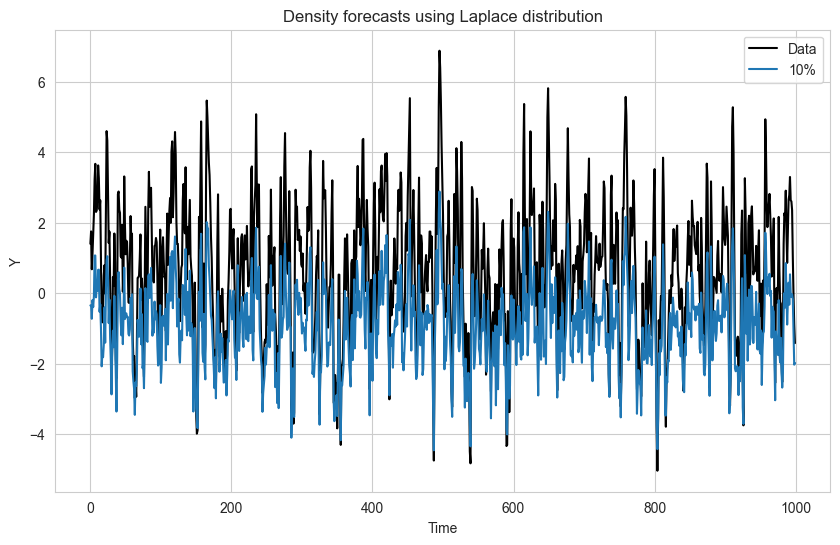

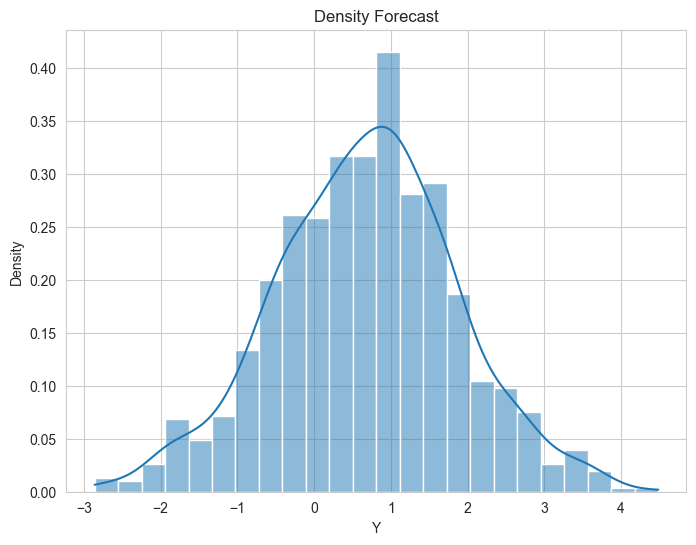

In [168]:

import numpy as np
from scipy.stats import norm
#Step 2: Generate Density Forecasts
T = len(y)
alpha_l, beta_l, gamma_l = beta_laplace # Extract parameters from Laplace estimation

#Set quantile levels
quantiles = [0.1, 0.5, 0.9,]
num_quantiles = len(quantiles)

#Generate density forecasts for each quantile level
density_forecasts = np.zeros((T, num_quantiles))
for i, q in enumerate(quantiles):
    for t in range(T):
        mu = alpha_l + beta_l * y[t] + gamma_l * x[t]
        density_forecasts[t, i] = mu + norm.ppf(q) * sigma_hat * np.sqrt(1 + theta_hat**2)

#Step 3: Plot density forecasts
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(10, 6))

#Plot data
ax.plot(y, color='black', label='Data')

#Plot density forecasts
for i, q in enumerate(quantiles):
    ax.plot(density_forecasts[:, i], label='{}%'.format(int(q * 100)))
    ax.legend()
    ax.set(title='Density forecasts using Laplace distribution', xlabel='Time', ylabel='Y')
    plt.show()

# Step 3: Plot density forecast using histogram
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(density_forecasts[:, 1], kde=True, stat='density', ax=ax)
ax.set_xlabel('Y')
ax.set_ylabel('Density')
ax.set_title('Density Forecast')
plt.show()

In [ ]:
''' 13/06 making EM + FGLS instead of OLS'''
def EM_Algorithm2(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior):
    y = df['y'].values
    x = df['x'].values
    y = np.array(y)
    x = np.array(x)
    T = len(x)
    β_values = np.zeros((1, 3))  # Array to store β parameters
    rmse_ = np.zeros((1, 3)) 
    τ_2 = 2 / (p * (1 - p))
    τ = np.sqrt(τ_2)
    θ = (1 - 2 * p) / (p * (1 - p))
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    y_lag = y_lag.reshape((-1, 1))
    y = y.reshape((-1, 1))
    X = np.column_stack((np.ones_like(x), y_lag, x))
    l = np.ones((len(x), 1))
    U = np.zeros((len(x), len(x)))
    l = l.reshape((-1, 1))
    np.fill_diagonal(Σ, sigma_ini)
    np.random.seed(42)
    z = np.random.exponential(1, T)
    z = z.reshape((-1, 1))

    # EM Algorithm iterations
    for i in range(M):
        alpha = alpha_prior + (3 * n / 2)
        #gamma
        res = np.zeros((len(x), 1))  # Initialize as zeros
        denomin = np.zeros((len(x), 1))  # Initialize as zeros
        for j in range(T):  
            res[j] = (y[j] - X[j] @ β - θ * z[j]) ** 2
            denomin[j] = (2 * z[j] * τ_2) + z[j]
        gamma = gamma_prior + np.sum(res) / np.sum(denomin)  # Sum the arrays

        #print('gamma:', gamma)
        mode_sigma = gamma / (alpha + 1)
        sigma = mode_sigma

        u = (sigma * τ_2 * z) ** -1
        np.fill_diagonal(U, u)

        r = θ / (sigma * τ_2)
        m_ = Σ @ ((X.T @ U) @ y) - ((r) * (X.T @ l))
        β = m_

        e = y - X @ β
# Calculating rho (correlation between error i and error j)
        rho = np.corrcoef(e[:-1], e[1:])[0, 1]
        print(rho)
        sigma2 = np.var(e)
        #C = np.cov(e[:-1], e[1:])[0, 1]

        #n = len(e)
        #Sigma = np.zeros((n, n))
        #Sigma[np.diag_indices(n)] = sigma2
        #for f in range(n):
            #for d in range(n):
                #if f != d:
                    #Sigma[f, d] = C * rho ** np.abs(f - d)
        #print(Sigma)
        autocov = np.full(len(e), sigma2 * rho)
        autocov[0] = sigma2

# Construct the variance-covariance matrix Sigma
        Sigma = toeplitz(autocov)

        print(Sigma)
        #μ
    
        μ = np.sqrt(θ ** 2 + 2 * τ_2) / (np.sum(np.abs(Sigma * y - X @ β * Sigma)))
        print('μ:', μ)
        λ = (θ ** 2 + 2 * τ_2) / (sigma * τ_2)
        mode_z_inverse = μ * (np.sqrt(1 + (9 * (μ ** 2)) / (4 * (λ ** 2))) - (3 * μ) / (4 * λ))
        z_inverse = mode_z_inverse
        z[i] = 1 / mode_z_inverse
        β_values = np.concatenate((β_values, β.flatten()[:len(x)].reshape(1, -1)), axis=0)  # Store β parameters
        Σ = np.linalg.inv((X.T @ U) @ X)
        print(f'Iteration {i+1}: {β_values[-1]}')  # Print the β parameters for each iteration

        actuals = np.array([0.2, 0.5, 0.3])  # True parameters alpha, beta, gamma
        biases = actuals - np.array(β)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE

        print("\nRMSE:")
        print(rmse)
        
    return β_values

In [ ]:
n = 1000
p = 0.5
df = df.astype('float64')
M = 2 # Number of iterations
sigma_ini = 1.55
β = np.array([0.16649059, 0.74366533, 0.29377513]) #input result of OLS
Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
EM_Algorithm2(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior)

In [ ]:

# Estimate rho, sigma2, and C
rho = np.corrcoef(z[:-1], z[1:])[0, 1]
sigma2 = np.var(z)
C = np.cov(z[:-1], z[1:])[0, 1]

# Construct the variance-covariance matrix Sigma
n = len(z)
Sigma = np.zeros((n, n))
Sigma[np.diag_indices(n)] = sigma2
for i in range(n):
    for j in range(n):
        if i != j:
            Sigma[i, j] = C * rho ** np.abs(i - j)

# Print the constructed variance-covariance matrix
print("Variance-Covariance Matrix (Sigma):")
print(Sigma)

In [ ]:
''' prove 13/09'''
df = df.astype('float64')
x = df['x'].values
y = df['y'].values
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))
beta_ha = np.linalg.inv(X.T @ X) @ X.T @ y
z = y - X @ beta_ha
print(beta_ha)
print(np.sum(z))


# Calculating rho (correlation between error i and error j)
rho = np.corrcoef(z[:-1], z[1:])[0, 1]
sigma2 = np.var(z)
C = np.cov(z[:-1], z[1:])[0, 1]

print("rho:", rho)
print("sigma2:", sigma2)
print(C)

In [ ]:
# Estimate rho, sigma2, and C
rho = np.corrcoef(z[:-1], z[1:])[0, 1]
sigma2 = np.var(z)
C = np.cov(z[:-1], z[1:])[0, 1]

# Construct the variance-covariance matrix Sigma
n = len(z)
Sigma = np.zeros((n, n))
Sigma[np.diag_indices(n)] = sigma2
for i in range(n):
    for j in range(n):
        if i != j:
            Sigma[i, j] = C * rho ** np.abs(i - j)

# Print the constructed variance-covariance matrix
print("Variance-Covariance Matrix (Sigma):")
print(Sigma)


In [ ]:
from scipy.linalg import toeplitz
# Estimate rho and sigma2
rho = np.corrcoef(z[:-1], z[1:])[0, 1]
sigma2 = np.var(z)

# Construct the autocovariance vector
autocov = np.full(len(z), sigma2 * rho)
autocov[0] = sigma2

# Construct the variance-covariance matrix Sigma
Sigma = toeplitz(autocov)

# Print the constructed variance-covariance matrix
print("Variance-Covariance Matrix (Sigma):")
print(Sigma)


FORECASTING NOTES

In [ ]:
T = [-0.00509, -0.00751, -0.01003, -0.01024, -0.01142, -0.00365, 0.00038, 0.00771,
     0.01518, 0.01199, 0.01388, 0.01456, 0.01678, 0.01943, 0.01866, 0.01972,
     0.01891, 0.01665, 0.01725, 0.02018, 0.02144, 0.02696, 0.02994, 0.03045,
     0.02361, 0.02113, 0.01349, 0.01188, 0.01818, 0.01593, 0.01791, 0.01162,
     -0.02888, -0.15362, -0.03923, -0.04202, -0.00839, 0.13288, 0.03867, 0.04664,
     0.05359, 0.04239, 0.02317]

L = [0.012899944960616111, 0.01340248398741282, 0.013959881552003176, 0.014437251850996804,
     0.014925851923821983, 0.01525956962074006, 0.015492874011419501, 0.015572531904772714,
     0.015522428851595022, 0.015526294728748306, 0.015508365788830825, 0.015488387761969145,
     0.015404443928855703, 0.015220029344448464, 0.015114998590339502, 0.01493713117765885,
     0.014833478419921173, 0.014769407605092402, 0.014705335046533034, 0.01445363241702659,
     0.014089779892090612, 0.013470022228539864, 0.012676344521056183, 0.011786811053349078,
     0.011124162945656739, 0.010506490803165047, 0.01014653520639801, 0.009847146818242829,
     0.009249466858962292, 0.0086321858508726, 0.007758825973519971, 0.007112785961886598,
     0.009467065143530734, 0.022552315879037232, 0.028195100379718452, 0.03534425552195625,
     0.04046362501940504, 0.02854088984532409, 0.026839313435457434, 0.022788832427934,
     0.015217310465483948, 0.006075166270933754, -0.0033923858578879997]

O = [0.01320983142174059, 0.013719748697611688, 0.014284884425865434, 0.014770379796705615,
     0.015267521611728459, 0.015610230616223023, 0.015853012331104706, 0.015942674066671395,
     0.015903146503833662, 0.015918209958993967, 0.01591215723817484, 0.01590479769410516,
     0.01583428643944772, 0.015664199938726878, 0.01557448541200683, 0.015413028242957153,
     0.015327001302452747, 0.015281912136952113, 0.015238339759667135, 0.015008845659874611,
     0.014669132841149415, 0.014075709402555887, 0.013310873941453921, 0.012453066944766701,
     0.01182548493662266, 0.011246775126962406, 0.010930365666889333, 0.010679966682514856,
     0.010137808047519122, 0.009583979981469207, 0.008783835037239394, 0.00822321244758264,
     0.010678439491562778, 0.02388482766187248, 0.029675669027313174, 0.0370098952505003,
     0.04236721328059826, 0.030761742816716172, 0.029504337001127933, 0.02612011188502212,
     0.01965901640826811, 0.012737725185109999, 0.009932731970464488]


dm_test(T, O, L, one_sided=True)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

def recursive_poos(df, horizon, beta):
    # Initialize variables
    vintages = df['TIME'].unique()[:-horizon]
    mse_list = []

    for vintage in vintages:
        # Split data into estimation sample and test sample
        df_estimation = df[df['TIME'] <= vintage]
        df_test = df[df['TIME'] > vintage]

        # Extract variables
        y_estimation = df_estimation['GDPgrowth(annualized)'].values
        x_estimation = df_estimation['CISS'].values

        y_test = df_test['GDPgrowth(annualized)'].values
        x_test = df_test['CISS'].values

        # Estimate model parameters
        y_estimation_lag = np.roll(y_estimation, 1)
        y_estimation_lag[0] = 0
        X_estimation = np.column_stack((np.ones_like(x_estimation), y_estimation_lag, x_estimation))

        # Generate forecasts for the test sample
        y_test_lag = np.roll(y_test, 1)
        y_test_lag[0] = 0
        X_test = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_forecast = X_test @ beta

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_forecast)
        mse_list.append(mse)

        vintage_pd = pd.Timestamp(vintage)
        if horizon == 1 and vintage_pd.year in [2008, 2014] and vintage_pd.quarter == 4:
            print(f"Mean of y forecasted values for vintage {vintage}: {np.mean(y_forecast)}")

    return mse_list


df = pd.read_excel('EA_GDP.xlsx')
df['TIME'] = pd.to_datetime(df['TIME'])
df = df.set_index('TIME')

horizons = [1, 2, 3, 4, 5, 6, 7, 8]

beta_lap = np.array([0.00774911, 0.79202651, -0.02741974])
beta_em = np.array([0.00787901, 0.93787018, -0.05776727])
beta_ols = np.array([0.148382, -0.03524024, -0.61258415])
beta_gls = np.array([0.1480470, -0.0308996, -0.6116255])

betas = [beta_lap, beta_em, beta_ols, beta_gls]
beta_names = ['beta_lap', 'beta_em', 'beta_ols', 'beta_gls']

mse_values = []  # List to store the average MSE values for each horizon and beta combination

for beta, beta_name in zip(betas, beta_names):
    for horizon in horizons:
        mse_list = recursive_poos(df_complete, horizon, beta)
        avg_mse = np.mean(mse_list)
        mse_values.append((beta_name, horizon, avg_mse))

        if horizon == 1:
            print(f"Average MSE for {beta_name}, horizon {horizon}: {avg_mse}")

# Print the mean of y forecasted values for all vintages in the test dataset using beta_lap
if 'beta_ols' in beta_names:
    vintages = df_complete['TIME'].unique()
    print("\nMean of y forecasted values for all vintages using beta_lap:")
    for vintage in vintages:
        df_test_vintage = df_complete[df_complete['TIME'] > vintage]
        y_test_vintage = df_test_vintage['GDPgrowth(annualized)'].values
        x_test_vintage = df_test_vintage['CISS'].values

        y_test_vintage_lag = np.roll(y_test_vintage, 1)
        #y_test_vintage_lag[0] = 0
        X_test_vintage = np.column_stack((np.ones_like(x_test_vintage), y_test_vintage_lag, x_test_vintage))
        y_forecast_vintage = X_test_vintage @ beta_lap

        mean_forecast_vintage = np.mean(y_forecast_vintage)
        print(f"Vintage {vintage}: {mean_forecast_vintage}")

# Print the mse_values list
for beta_name, horizon, avg_mse in mse_values:
    print(f"Average MSE for {beta_name}, horizon {horizon}: {avg_mse}")

In [ ]:
def recursive_poos(df, horizon, beta):
    # Initialize variables
    vintages = df['TIME'].unique()[:-horizon]
    mse_list = []

    for vintage in vintages:
        # Split data into estimation sample and test sample
        df_estimation = df[df['TIME'] <= vintage]
        df_test = df[df['TIME'] > vintage]

        # Extract variables
        y_estimation = df_estimation['GDPgrowth(annualized)'].values
        x_estimation = df_estimation['CISS'].values

        y_test = df_test['GDPgrowth(annualized)'].values
        x_test = df_test['CISS'].values

        # Estimate model parameters
        y_estimation_lag = np.roll(y_estimation, 1)
        y_estimation_lag[0] = 0
        X_estimation = np.column_stack((np.ones_like(x_estimation), y_estimation_lag, x_estimation))

        # Generate forecasts for the test sample
        y_test_lag = np.roll(y_test, 1)
        y_test_lag[0] = 0
        X_test = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_forecast = X_test @ beta

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_forecast)
        mse_list.append(mse)

        vintage_pd = pd.Timestamp(vintage)
        if horizon == 1 and vintage_pd.year in [2008, 2014] and vintage_pd.quarter == 4:
            print(f"Mean of y forecasted values for vintage {vintage}: {np.mean(y_forecast)}")

    return mse_list

df = pd.read_excel('EA_GDP.xlsx')
df['TIME'] = pd.to_datetime(df['TIME'])
df = df.set_index('TIME')

horizons = [1, 2, 3, 4, 5, 6, 7, 8]

beta_lap = np.array([0.00774911, 0.79202651, -0.02741974])
beta_em = np.array([0.00787901, 0.93787018, -0.05776727])
beta_ols = np.array([0.148382, -0.03524024, -0.61258415])
beta_gls = np.array([0.1480470, -0.0308996, -0.6116255])

betas = [beta_lap, beta_em, beta_ols, beta_gls]
beta_names = ['beta_lap', 'beta_em', 'beta_ols', 'beta_gls']

mse_values = []  # List to store the average MSE values for each horizon and beta combination

for beta, beta_name in zip(betas, beta_names):
    for horizon in horizons:
        mse_list = recursive_poos(df_complete, horizon, beta)
        avg_mse = np.mean(mse_list)
        mse_values.append((beta_name, horizon, avg_mse))

        if horizon == 1:
            print(f"Average MSE for {beta_name}, horizon {horizon}: {avg_mse}")

# Print the mse_values list
for beta_name, horizon, avg_mse in mse_values:
    print(f"Average MSE for {beta_name}, horizon {horizon}: {avg_mse}")



In [ ]:
from scipy.stats import t

def diebold_mariano_test(mse1, mse2, h, alpha):
    # Calculate the difference in MSE
    diff = [mse1 - mse2]

    # Calculate the test statistic
    n = len(diff)
    se = np.sqrt(np.var(diff) / n)
    t_stat = np.mean(diff) / se

    # Calculate the critical value
    df = n - h
    crit_val = t.ppf(1 - alpha / 2, df)

    # Perform the test
    if np.abs(t_stat) > crit_val:
        return True  # Reject the null hypothesis (significant difference)
    else:
        return False  # Fail to reject the null hypothesis (no significant difference)

# Extract the MSE values for beta_gls and beta_ols at horizon 1
mse_gls_horizon1 = [mse for beta_name, horizon, mse in mse_values if beta_name == 'beta_gls' and horizon == 1][0]
mse_ols_horizon1 = [mse for beta_name, horizon, mse in mse_values if beta_name == 'beta_ols' and horizon == 1][0]
mse_lap_horizon1 = [mse for beta_name, horizon, mse in mse_values if beta_name == 'beta_lap' and horizon == 1][0]
mse_em_horizon1 = [mse for beta_name, horizon, mse in mse_values if beta_name == 'beta_em' and horizon == 1][0]
# Set the significance levels for the test
significance_levels = [0.1, 0.05, 0.01]

# Perform the Diebold-Mariano test
for alpha in significance_levels:
    is_different = diebold_mariano_test(mse_gls_horizon1, mse_ols_horizon1, h=1, alpha=alpha)
    if is_different:
        print(f"Average MSE for beta_gls is significantly different from beta_ols at horizon 1 (alpha={alpha})")
    else:
        print(f"Average MSE for beta_gls is not significantly different from beta_ols at horizon 1 (alpha={alpha})")


# Perform the Diebold-Mariano test for beta_lap and beta_ols
for alpha in significance_levels:
    is_different = diebold_mariano_test(mse_lap_horizon1, mse_ols_horizon1, h=1, alpha=alpha)
    if is_different:
        print(f"Average MSE for beta_lap is significantly different from beta_ols at horizon 1 (alpha={alpha})")
    else:
        print(f"Average MSE for beta_lap is not significantly different from beta_ols at horizon 1 (alpha={alpha})")

# Perform the Diebold-Mariano test for beta_em and beta_ols
for alpha in significance_levels:
    is_different = diebold_mariano_test(mse_em_horizon1, mse_ols_horizon1, h=1, alpha=alpha)
    if is_different:
        print(f"Average MSE for beta_em is significantly different from beta_ols at horizon 1 (alpha={alpha})")
    else:
        print(f"Average MSE for beta_em is not significantly different from beta_ols at horizon 1 (alpha={alpha})")

In [ ]:
def recursive_poos(df, horizon, beta):
    # Initialize variables
    vintages = df['TIME'].unique()[:-horizon]
    mse_list = []

    for vintage in vintages:
        # Split data into estimation sample and test sample
        df_estimation = df[df['TIME'] <= vintage]
        df_test = df[df['TIME'] > vintage]

        # Extract variables
        y_estimation = df_estimation['GDPgrowth(annualized)'].values
        x_estimation = df_estimation['CISS'].values

        y_test = df_test['GDPgrowth(annualized)'].values
        x_test = df_test['CISS'].values

        # Estimate model parameters
        y_estimation_lag = np.roll(y_estimation, 1)
        y_estimation_lag[0] = 0
        X_estimation = np.column_stack((np.ones_like(x_estimation), y_estimation_lag, x_estimation))
        

        # Generate forecasts for the test sample
        y_test_lag = np.roll(y_test, 1)
        y_test_lag[0] = 0
        X_test = np.column_stack((np.ones_like(x_test), y_test_lag, x_test))
        y_forecast = X_test @ beta

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_test, y_forecast)
        mse_list.append(mse)
        
    return mse_list

In [ ]:
from scipy.stats import t

def diebold_mariano_test(mse1, mse2, h, alpha):
    # Calculate the difference in MSE
    diff = [mse1 - mse2]

    # Calculate the test statistic
    n = len(diff)
    se = np.sqrt(np.var(diff) / n)
    t_stat = np.mean(diff) / se

    # Calculate the critical value
    df = n - h
    crit_val = t.ppf(1 - alpha / 2, df)

    # Perform the test
    if np.abs(t_stat) > crit_val:
        return True  # Reject the null hypothesis (significant difference)
    else:
        return False  # Fail to reject the null hypothesis (no significant difference)

# Extract the MSE values for beta_gls and beta_ols at horizon 1
mse_gls_horizon1 = [mse for beta_name, horizon, mse in mse_values if beta_name == 'beta_gls' and horizon == 1][0]
mse_ols_horizon1 = [mse for beta_name, horizon, mse in mse_values if beta_name == 'beta_ols' and horizon == 1][0]
mse_lap_horizon1 = [mse for beta_name, horizon, mse in mse_values if beta_name == 'beta_lap' and horizon == 1][0]
mse_em_horizon1 = [mse for beta_name, horizon, mse in mse_values if beta_name == 'beta_em' and horizon == 1][0]
# Set the significance levels for the test
significance_levels = [0.1, 0.05, 0.01]

# Perform the Diebold-Mariano test
for alpha in significance_levels:
    is_different = diebold_mariano_test(mse_gls_horizon1, mse_ols_horizon1, h=1, alpha=alpha)
    if is_different:
        print(f"Average MSE for beta_gls is significantly different from beta_ols at horizon 1 (alpha={alpha})")
    else:
        print(f"Average MSE for beta_gls is not significantly different from beta_ols at horizon 1 (alpha={alpha})")


# Perform the Diebold-Mariano test for beta_lap and beta_ols
for alpha in significance_levels:
    is_different = diebold_mariano_test(mse_lap_horizon1, mse_ols_horizon1, h=1, alpha=alpha)
    if is_different:
        print(f"Average MSE for beta_lap is significantly different from beta_ols at horizon 1 (alpha={alpha})")
    else:
        print(f"Average MSE for beta_lap is not significantly different from beta_ols at horizon 1 (alpha={alpha})")

# Perform the Diebold-Mariano test for beta_em and beta_ols
for alpha in significance_levels:
    is_different = diebold_mariano_test(mse_em_horizon1, mse_ols_horizon1, h=1, alpha=alpha)
    if is_different:
        print(f"Average MSE for beta_em is significantly different from beta_ols at horizon 1 (alpha={alpha})")
    else:
        print(f"Average MSE for beta_em is not significantly different from beta_ols at horizon 1 (alpha={alpha})")